In [36]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
import numpy as np

print("TensorFlow version is: {}".format(tf.__version__))
print("Eager execution is: {}".format(tf.executing_eagerly()))
print("Keras version is: {}".format(tf.keras.__version__))

TensorFlow version is: 2.2.0
Eager execution is: True
Keras version is: 2.3.0-tf


In [37]:
def read_labels(labels_path):
    with open(labels_path) as f:
        labels = f.readlines()
    labels = [c.strip() for c in labels]
    return labels

In [38]:
labels = read_labels('coco.txt')
labels[:5]

['person', 'bicycle', 'car', 'motorbike', 'aeroplane']

In [39]:
# load yolo model
yolo_tiny_model = load_model('yolov5-tiny-608-4thJun')

In [40]:
yolo_tiny_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 608, 608, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 609, 609, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 304, 304, 32) 864         zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 304, 304, 32) 128         conv2d[0][0]                     
______________________________________________________________________________________________

In [41]:
from tensorflow.keras.layers import Lambda
from tensorflow import slice

In [42]:
num_pred = 0
num_classes = len(labels)
total_len = 4 + num_classes
test_arr = np.random.randint(100, size = num_pred * total_len).reshape(1, num_pred, total_len)
test_arr

array([], shape=(1, 0, 84), dtype=int64)

In [43]:
inputs = tf.keras.layers.Input(shape=(None, total_len), name='model_input')
slice_x0 = tf.keras.layers.Lambda( lambda x: x[..., 0], name = 'all_x0')(inputs)
slice_y0 = tf.keras.layers.Lambda(lambda x: x[..., 1], name = 'all_y0')(inputs)


slice_width = tf.keras.layers.Lambda(lambda x: x[..., 2], name = 'all_widths')(inputs)


slice_height = tf.keras.layers.Lambda( lambda x: x[..., 3], name = 'all_heights')(inputs)

# slice_height = tf.keras.layers.Subtract()([slice_y1, slice_y0])
# slice_width = tf.keras.layers.Subtract()([slice_x1, slice_x0])

# concatenate_x0_y0 = tf.keras.layers.Concatenate(axis = 0, name='concatenate_x0_y0')([slice_x0, slice_y0, slice_x1, slice_y1])
# transpose_dims = tf.keras.layers.Lambda(lambda x: tf.transpose(x), name ='all_boxes')(concatenate_x0_y0)

concatenate_x0_y0_x1_y1 = tf.keras.layers.Concatenate(axis = 0, name='concatenate_x0_y0_x1_y1')([slice_x0, slice_y0, slice_width, slice_height])
x_y_w_h = tf.keras.layers.Lambda(lambda x: tf.transpose(x), name ='x_y_w_h')(concatenate_x0_y0_x1_y1)
# normalized_x_y_w_h = tf.keras.layers.Lambda(lambda x: x/608.0, name ='normalized_x_y_w_h')(x_y_w_h)

slice_confidences = tf.keras.layers.Lambda(lambda x: x[..., 4:], name = 'slice_confidences')(inputs)
scores = tf.keras.layers.Lambda(lambda x: tf.squeeze(x, axis=0), name = 'all_scores')(slice_confidences)


decoder_model = tf.keras.Model(inputs = [inputs], outputs = [x_y_w_h, scores ], name = 'yolo_decoder')

In [44]:
decoder_model.summary()

Model: "yolo_decoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
model_input (InputLayer)        [(None, None, 84)]   0                                            
__________________________________________________________________________________________________
all_x0 (Lambda)                 (None, None)         0           model_input[0][0]                
__________________________________________________________________________________________________
all_y0 (Lambda)                 (None, None)         0           model_input[0][0]                
__________________________________________________________________________________________________
all_widths (Lambda)             (None, None)         0           model_input[0][0]                
_______________________________________________________________________________________

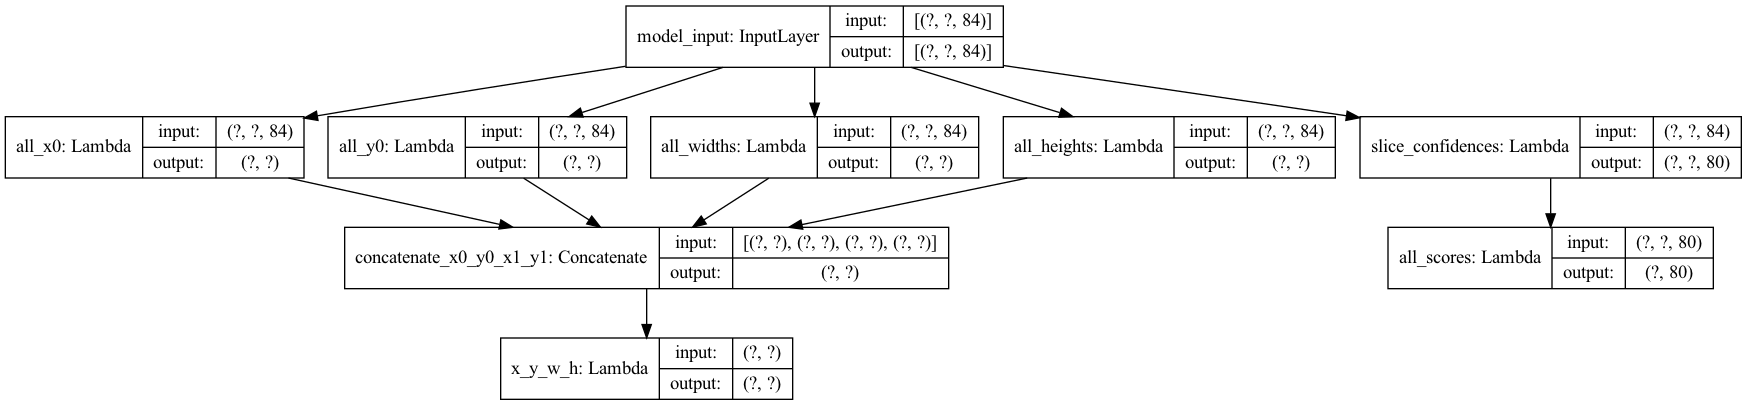

In [45]:
tf.keras.utils.plot_model(decoder_model, "decoder_model.png", show_shapes=True)

In [46]:
test_arr

array([], shape=(1, 0, 84), dtype=int64)

In [47]:
decoder_model.predict(test_arr)

[array([], shape=(0, 4), dtype=float32),
 array([], shape=(0, 80), dtype=float32)]

In [48]:
# merge yolo and decoder
x = yolo_tiny_model.outputs[0]
x.shape
decoder_model.input.shape

inputs = tf.keras.layers.Input(shape=(608, 608, 3))
x = yolo_tiny_model(inputs)
predictions = decoder_model(x)
combined_model = tf.keras.Model(inputs=inputs, outputs=predictions)
combined_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 608, 608, 3)]     0         
_________________________________________________________________
model (Model)                (None, None, None)        6062814   
_________________________________________________________________
yolo_decoder (Model)         [(None, None), (None, 80) 0         
Total params: 6,062,814
Trainable params: 6,056,606
Non-trainable params: 6,208
_________________________________________________________________


In [49]:
combined_model.save('yolo_decoded.h5')

# check predictions

In [50]:
import colorsys
import random

def generate_colors(class_names):
    hsv_tuples = [(x / len(class_names), 1., 1.) for x in range(len(class_names))]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(map(lambda x: (int(x[0] ), int(x[1] ), int(x[2] )), colors))
    random.seed(10101)  # Fixed seed for consistent colors across runs.
    random.shuffle(colors)  # Shuffle colors to decorrelate adjacent classes.
    random.seed(None)  # Reset seed to default.
    return colors

In [51]:
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

# load and prepare an image
def load_image_pixels(filename, shape):
    # load the image to get its shape
    image = load_img(filename)
    width, height = image.size
    # load the image with the required size
    image = load_img(filename, interpolation = 'bilinear', target_size=shape)
    # convert to numpy array
    image = img_to_array(image)
    # scale pixel values to [0, 1]
    image = image.astype('float32')
    image /= 255.0

    # add a dimension so that we have one sample
    image = expand_dims(image, 0)
    
    return image, width, height

In [52]:
from matplotlib import pyplot
from matplotlib.patches import Rectangle

def draw_preds_bbs(file_name, preds_pipeline, is_coreml = False):
    print(preds_pipeline[0].shape)
    print(preds_pipeline[1].shape)
    boxes = preds_pipeline[0]
    scores = preds_pipeline[1]
#     boxes = preds_pipeline[2]

    print('start drawing boxes')
    data = pyplot.imread(file_name)
    ax = pyplot.gca()
    colors = generate_colors(labels)
    for i in range(len(boxes)):
        index = i # nms_ids[i]
        box = boxes[index]
#         w_h_box = w_h_boxes[i]
        class_id = np.argmax(scores[i])
        score = scores[i][class_id]

#         y1, x1, y2, x2 = box[0], box[1], box[2], box[3]
#         width, height = x2 - x1, y2 - y1
        if is_coreml == False :
            x1, y1, height, width = box[0], box[1], box[2], box[3]
        else:
            x1, y1, width, height = box[0], box[1], box[2], box[3]
        
#         width, height = x2 - x1, y2 - y1
        
#         rect = Rectangle(
#             (x1 * image_w, y1 * image_h),
#             width * image_w,
#             height * image_h,
#             fill=False,
#             color=colors[class_id]
#         )
        x1, y1, width, height = box[0], box[1], box[2], box[3]
#         x1, y1, x2, y2 = box[0], box[1], box[2], box[3]
#         w_x1, w_y1, w_width, w_height = w_h_box[0], w_h_box[1], w_h_box[2], w_h_box[3]
        
        
        x1 = x1- width/2.0
        y1 = y1- height/2.0
        
#         width = x2-x1
#         height = y2-y1
        
#         print(f'-- n -- x0 = {x1}, y0 ={y1}, w = {width}, h ={height}')
#         print(f'-- w -- x0 = {w_x1}, y0 ={w_y1}, w = {w_width}, h ={w_height}')
#         width = w_width
#         height = w_height
        rect = Rectangle(
            (x1 * image_w, y1 * image_h),
            width * image_w,
            height * image_h,
            fill=False,
            color=colors[class_id]
        )
        ax.add_patch(rect)
        label = "%s (%.3f)" % (labels[class_id], score*100)
        pyplot.text(
            x1* image_w,
            y1* image_h,
            label, 
            color= 'white'
        )
    pyplot.imshow(data)
    pyplot.show()

In [66]:
# Pre-process the image
input_w, input_h = 608, 608
photo_filename = '/Users/ankit/Desktop/test_image_samples/ios_sample2.png'
# photo_filename = 'empty_image.jpg'
image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))
print("image initial size: ", image_w, image_h)
print("input image",image.shape)

image initial size:  680 680
input image (1, 608, 608, 3)


In [67]:
ytinyhat = combined_model.predict(image)
# print(f"ytinyhat shape : {ytinyhat.shape}")
# draw_preds_bbs(photo_filename, ytinyhat)

In [68]:
ytinyhat

[array([[0.4956739 , 0.04093173, 0.03223347, 0.04312926],
        [0.5458241 , 0.04289844, 0.02819124, 0.04182098],
        [0.58671653, 0.03721503, 0.0263587 , 0.04378143],
        [0.6247155 , 0.04633791, 0.02758353, 0.0673338 ],
        [0.7024591 , 0.04421607, 0.03174308, 0.07020433]], dtype=float32),
 array([[7.12421611e-02, 4.06510189e-05, 2.36979668e-05, 1.80610368e-05,
         2.44456547e-04, 3.41022474e-06, 1.67562685e-05, 6.61600779e-06,
         3.95777715e-05, 9.24369815e-05, 6.05336245e-05, 1.25958351e-04,
         3.85818385e-05, 2.75417387e-05, 2.89000839e-01, 2.25313287e-03,
         3.82514205e-03, 6.60027727e-04, 1.09675666e-03, 1.51676184e-03,
         2.11404506e-04, 3.20071063e-04, 9.72663329e-05, 2.98666302e-04,
         5.88538496e-05, 1.90629653e-04, 1.11936242e-05, 2.46844629e-05,
         3.01359955e-06, 2.48733213e-05, 4.41125485e-05, 5.37404194e-05,
         3.94672796e-04, 1.25669339e-03, 9.27474412e-06, 4.17749980e-05,
         1.46165054e-04, 1.83626486e

In [56]:
ytinyhat[1][0].shape

(80,)

# Core ml

In [57]:
import coremltools as ct
from coremltools.models.neural_network import datatypes, NeuralNetworkBuilder

In [58]:
image_input = ct.ImageType(shape=(1,608, 608, 3), scale =1/255.0)

coreml_model = ct.convert('yolo_decoded.h5', inputs=[image_input], source= 'tensorflow', minimum_deployment_target=ct.target.iOS14)

Translating MIL ==> MLModel Ops: 100%|█████| 488/488 [00:01<00:00, 475.13 ops/s]


In [59]:
print(coreml_model)

input {
  name: "input_1"
  type {
    imageType {
      width: 608
      height: 608
      colorSpace: RGB
    }
  }
}
output {
  name: "Identity"
  type {
    multiArrayType {
      dataType: FLOAT32
    }
  }
}
output {
  name: "Identity_1"
  type {
    multiArrayType {
      dataType: FLOAT32
    }
  }
}
metadata {
  userDefined {
    key: "com.github.apple.coremltools.source"
    value: "tensorflow==2.2.0"
  }
  userDefined {
    key: "com.github.apple.coremltools.version"
    value: "4.0b3"
  }
}



In [60]:
from PIL import Image
def load_local_and_scale_image(image_path, shape):
    image = Image.open(image_path)
    return image.resize(shape)

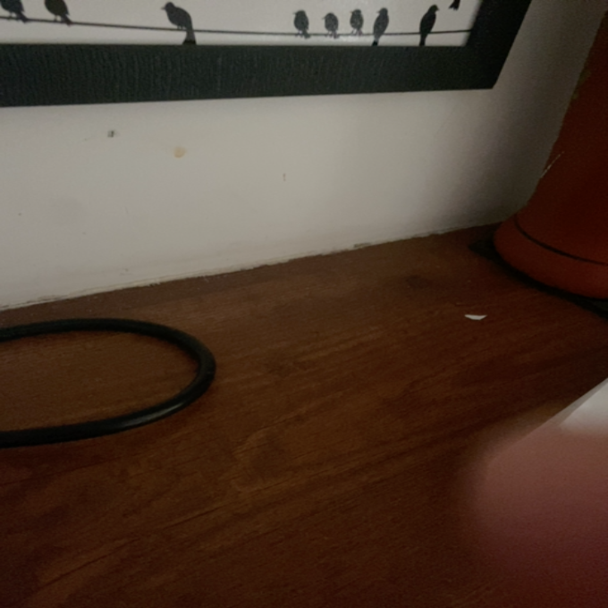

In [69]:
test_image = load_local_and_scale_image(photo_filename, (608, 608)) 
test_image

In [70]:
INPUT_NODE = coreml_model.get_spec().description.input[0].name
INPUT_NODE

'input_1'

In [71]:
preds_pipeline = coreml_model.predict(data={INPUT_NODE: test_image})

In [72]:
preds_pipeline

{'Identity_1': array([[6.10329537e-03, 8.63999776e-06, 3.00924385e-05, 3.03389807e-05,
         5.62833098e-04, 4.58246359e-06, 2.21342416e-05, 3.37615757e-06,
         2.97797058e-04, 9.90901535e-05, 2.72890611e-04, 3.70979251e-04,
         1.46401595e-04, 3.75420568e-05, 2.26675808e-01, 1.03449821e-03,
         5.98343264e-04, 8.08844852e-05, 2.25790245e-05, 1.72894303e-04,
         3.69580288e-04, 9.97323295e-05, 1.63908859e-04, 1.70552550e-04,
         8.00476409e-05, 1.55057735e-03, 7.04039558e-05, 1.20277691e-04,
         1.71107167e-05, 1.23850114e-05, 4.30292101e-04, 1.40567092e-04,
         4.79963637e-05, 4.32943401e-04, 5.31540791e-05, 1.19211189e-04,
         1.73849912e-04, 1.13357382e-04, 8.33089944e-05, 2.33541848e-03,
         1.71148946e-04, 3.82299295e-05, 1.40449591e-02, 2.92158453e-03,
         8.40779673e-03, 3.27172893e-05, 1.79469353e-05, 3.26343143e-05,
         3.41150990e-05, 6.33241234e-06, 8.33112135e-05, 2.51475449e-05,
         4.49093714e-05, 7.16283757e-

(6, 4)
(6, 80)
start drawing boxes


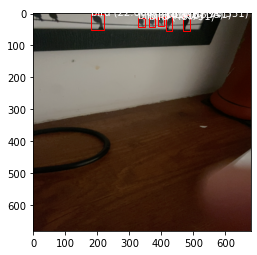

In [73]:
draw_preds_bbs(
    photo_filename, 
    [
        preds_pipeline['Identity'],
        preds_pipeline['Identity_1'],
        
    ],
    is_coreml=True
)

In [873]:
coreml_model.save('decoded_yolo_4thJune2022.mlmodel')

In [874]:
print(coreml_model)

input {
  name: "input_10"
  type {
    imageType {
      width: 608
      height: 608
      colorSpace: RGB
    }
  }
}
output {
  name: "Identity"
  type {
    multiArrayType {
      dataType: FLOAT32
    }
  }
}
output {
  name: "Identity_1"
  type {
    multiArrayType {
      dataType: FLOAT32
    }
  }
}
metadata {
  userDefined {
    key: "com.github.apple.coremltools.source"
    value: "tensorflow==2.2.0"
  }
  userDefined {
    key: "com.github.apple.coremltools.version"
    value: "4.0b3"
  }
}



# modify core ml

In [875]:
spec = coreml_model.get_spec()
spec.description


input {
  name: "input_10"
  type {
    imageType {
      width: 608
      height: 608
      colorSpace: RGB
    }
  }
}
output {
  name: "Identity"
  type {
    multiArrayType {
      dataType: FLOAT32
    }
  }
}
output {
  name: "Identity_1"
  type {
    multiArrayType {
      dataType: FLOAT32
    }
  }
}
metadata {
  userDefined {
    key: "com.github.apple.coremltools.source"
    value: "tensorflow==2.2.0"
  }
  userDefined {
    key: "com.github.apple.coremltools.version"
    value: "4.0b3"
  }
}

In [876]:
detector_builder = ct.models.neural_network.NeuralNetworkBuilder(spec= spec)

In [877]:
detector_builder.set_output(output_names=['Identity', 'Identity_1'], output_dims=[(0,4), (0,80)] )

In [878]:
detector_builder.spec.description

input {
  name: "input_10"
  type {
    imageType {
      width: 608
      height: 608
      colorSpace: RGB
    }
  }
}
output {
  name: "Identity"
  type {
    multiArrayType {
      shape: 0
      shape: 4
      dataType: DOUBLE
    }
  }
}
output {
  name: "Identity_1"
  type {
    multiArrayType {
      shape: 0
      shape: 80
      dataType: DOUBLE
    }
  }
}
metadata {
  userDefined {
    key: "com.github.apple.coremltools.source"
    value: "tensorflow==2.2.0"
  }
  userDefined {
    key: "com.github.apple.coremltools.version"
    value: "4.0b3"
  }
}

In [879]:
# flexible_shape_utils.set_multiarray_ndshape_range(detector_builder.spec, 
#                                  feature_name='Identity', 
#                                  lower_bounds=[0, 4], 
#                                  upper_bounds=[-1, 4])

In [880]:
# flexible_shape_utils.set_multiarray_ndshape_range(detector_builder.spec, 
#                                  feature_name='Identity_1', 
#                                  lower_bounds=[0, 80], 
#                                  upper_bounds=[-1, 80])

In [881]:
output_sizes=[4, 80]
for i in range(2):
    ma_type = detector_builder.spec.description.output[i].type.multiArrayType
    ma_type.shapeRange.sizeRanges.add()
    ma_type.shapeRange.sizeRanges[0].lowerBound = 0
    ma_type.shapeRange.sizeRanges[0].upperBound = -1
    ma_type.shapeRange.sizeRanges.add()
    ma_type.shapeRange.sizeRanges[1].lowerBound = output_sizes[i]
    ma_type.shapeRange.sizeRanges[1].upperBound = output_sizes[i]
    del ma_type.shape[:]

In [882]:
detector_builder.spec.description

input {
  name: "input_10"
  type {
    imageType {
      width: 608
      height: 608
      colorSpace: RGB
    }
  }
}
output {
  name: "Identity"
  type {
    multiArrayType {
      dataType: DOUBLE
      shapeRange {
        sizeRanges {
          upperBound: -1
        }
        sizeRanges {
          lowerBound: 4
          upperBound: 4
        }
      }
    }
  }
}
output {
  name: "Identity_1"
  type {
    multiArrayType {
      dataType: DOUBLE
      shapeRange {
        sizeRanges {
          upperBound: -1
        }
        sizeRanges {
          lowerBound: 80
          upperBound: 80
        }
      }
    }
  }
}
metadata {
  userDefined {
    key: "com.github.apple.coremltools.source"
    value: "tensorflow==2.2.0"
  }
  userDefined {
    key: "com.github.apple.coremltools.version"
    value: "4.0b3"
  }
}

In [883]:
yolo_coreml_model_modified = ct.models.MLModel(detector_builder.spec)

In [884]:
yolo_coreml_model_modified.save('decoder_yolo_coreml_model_modified.mlmodel')

# core ml 

In [885]:
from coremltools.models.neural_network import flexible_shape_utils

In [886]:
nms_spec = ct.proto.Model_pb2.Model()
nms_spec.specificationVersion = 3

In [887]:
nms = nms_spec.nonMaximumSuppression
nms.confidenceInputFeatureName = 'Identity_1'
nms.coordinatesInputFeatureName = 'Identity'
nms.confidenceOutputFeatureName = 'scores'
nms.coordinatesOutputFeatureName = 'boxes'
nms.iouThresholdInputFeatureName = 'iouThreshold'
nms.confidenceThresholdInputFeatureName = 'confidenceThreshold'

In [888]:
nms.iouThreshold = 0.5
nms.confidenceThreshold = 0.4
nms.pickTop.perClass = True

labels = np.loadtxt('coco.txt', dtype=str, delimiter='\n')
nms.stringClassLabels.vector.extend(labels)

In [889]:
for i in range(2):
    decoder_output = yolo_coreml_model_modified._spec.description.output[i].SerializeToString()
    print(f"{i} -- decoder output is {decoder_output}")
    nms_spec.description.input.add()
    nms_spec.description.input[i].ParseFromString(decoder_output)

    nms_spec.description.output.add()
    nms_spec.description.output[i].ParseFromString(decoder_output)

nms_spec.description.output[1].name = 'scores'
nms_spec.description.output[0].name = 'boxes'

0 -- decoder output is b'\n\x08Identity\x1a\x1c*\x1a\x10\xc0\x80\x04\xfa\x01\x13\n\x0b\x10\xff\xff\xff\xff\xff\xff\xff\xff\xff\x01\n\x04\x08\x04\x10\x04'
1 -- decoder output is b'\n\nIdentity_1\x1a\x1c*\x1a\x10\xc0\x80\x04\xfa\x01\x13\n\x0b\x10\xff\xff\xff\xff\xff\xff\xff\xff\xff\x01\n\x04\x08P\x10P'


In [890]:
nms_spec.description

input {
  name: "Identity"
  type {
    multiArrayType {
      dataType: DOUBLE
      shapeRange {
        sizeRanges {
          upperBound: -1
        }
        sizeRanges {
          lowerBound: 4
          upperBound: 4
        }
      }
    }
  }
}
input {
  name: "Identity_1"
  type {
    multiArrayType {
      dataType: DOUBLE
      shapeRange {
        sizeRanges {
          upperBound: -1
        }
        sizeRanges {
          lowerBound: 80
          upperBound: 80
        }
      }
    }
  }
}
output {
  name: "boxes"
  type {
    multiArrayType {
      dataType: DOUBLE
      shapeRange {
        sizeRanges {
          upperBound: -1
        }
        sizeRanges {
          lowerBound: 4
          upperBound: 4
        }
      }
    }
  }
}
output {
  name: "scores"
  type {
    multiArrayType {
      dataType: DOUBLE
      shapeRange {
        sizeRanges {
          upperBound: -1
        }
        sizeRanges {
          lowerBound: 80
          upperBound: 80
        }
 

In [623]:
# output_sizes=[4, 80]
# for i in range(2):
#     ma_type = nms_spec.description.output[i].type.multiArrayType
#     ma_type.shapeRange.sizeRanges.add()
#     ma_type.shapeRange.sizeRanges[0].lowerBound = 0
#     ma_type.shapeRange.sizeRanges[0].upperBound = -1
#     ma_type.shapeRange.sizeRanges.add()
#     ma_type.shapeRange.sizeRanges[1].lowerBound = output_sizes[i]
#     ma_type.shapeRange.sizeRanges[1].upperBound = output_sizes[i]
#     del ma_type.shape[:]

In [891]:
model_nms = ct.models.MLModel(nms_spec)
model_nms.save('yolo_nms.mlmodel')

# pipeline

In [892]:
input_features = [ (INPUT_NODE, datatypes.Array(1,1,1)), # Placeholder
                   ('iouThreshold', datatypes.Double()),
                   ('confidenceThreshold', datatypes.Double())
                 ]
output_features = [ 'scores', 'boxes' ]

In [893]:
pipeline = ct.models.pipeline.Pipeline(input_features, output_features)
pipeline.spec.specificationVersion = 3

pipeline.add_model(yolo_coreml_model_modified)
pipeline.add_model(model_nms)

# Update Pipeline description's inputs and outputs
pipeline.spec.description.input[0].ParseFromString(yolo_coreml_model_modified._spec.description.input[0].SerializeToString())
pipeline.spec.description.output[0].ParseFromString(model_nms._spec.description.output[1].SerializeToString())
pipeline.spec.description.output[1].ParseFromString(model_nms._spec.description.output[0].SerializeToString())

model_pipeline = ct.models.MLModel(pipeline.spec)

In [894]:
print(model_pipeline)

input {
  name: "input_10"
  type {
    imageType {
      width: 608
      height: 608
      colorSpace: RGB
    }
  }
}
input {
  name: "iouThreshold"
  type {
    doubleType {
    }
  }
}
input {
  name: "confidenceThreshold"
  type {
    doubleType {
    }
  }
}
output {
  name: "scores"
  type {
    multiArrayType {
      dataType: DOUBLE
      shapeRange {
        sizeRanges {
          upperBound: -1
        }
        sizeRanges {
          lowerBound: 80
          upperBound: 80
        }
      }
    }
  }
}
output {
  name: "boxes"
  type {
    multiArrayType {
      dataType: DOUBLE
      shapeRange {
        sizeRanges {
          upperBound: -1
        }
        sizeRanges {
          lowerBound: 4
          upperBound: 4
        }
      }
    }
  }
}



image initial size:  680 680
input image (1, 608, 608, 3)


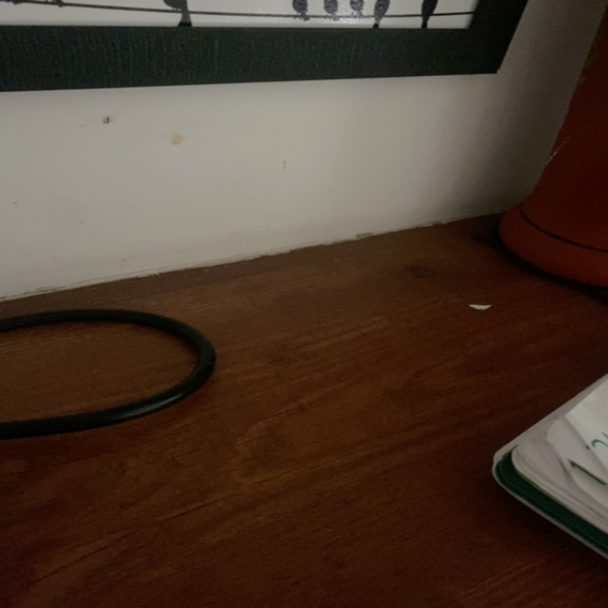

In [28]:
input_w, input_h = 608, 608
photo_filename = '/Users/ankit/Desktop/test_image_samples/ios_sample.png'
# photo_filename = 'empty_image.jpg'
image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))
print("image initial size: ", image_w, image_h)
print("input image",image.shape)
test_image = load_local_and_scale_image(photo_filename, (608, 608)) 
test_image

In [25]:
preds_pipeline = model_pipeline.predict(data={INPUT_NODE: test_image, 'iou' : .45, 'confidenceThreshold' : .7})

NameError: name 'model_pipeline' is not defined

(8, 4)
(8, 80)
start drawing boxes


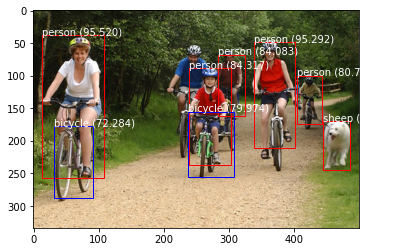

In [911]:
draw_preds_bbs(
    photo_filename, 
    [
        preds_pipeline['boxes'],
        preds_pipeline['scores'],
        
    ],
    is_coreml=True
)

In [912]:
model_pipeline.save('final_yolo_pipeline_4thJune2022.mlmodel')

In [913]:
quantized_model_pipeline = ct.models.neural_network.quantization_utils.quantize_weights(
    model_pipeline, 
    nbits=8, 
    quantization_mode='linear')

Quantizing using linear quantization
Optimizing Neural Network before Quantization:
Fused model_9/model/conv2d/Conv2Dx->batch_norm_190
Fused model_9/model/conv2d_1/Conv2Dx->batch_norm_191
Fused model_9/model/conv2d_2/Conv2Dx->batch_norm_192
Fused model_9/model/conv2d_3/Conv2Dx->batch_norm_193
Fused model_9/model/conv2d_4/Conv2Dx->batch_norm_194
Fused model_9/model/conv2d_5/Conv2Dx->batch_norm_195
Fused model_9/model/conv2d_6/Conv2Dx->batch_norm_196
Fused model_9/model/conv2d_7/Conv2Dx->batch_norm_197
Fused model_9/model/conv2d_8/Conv2Dx->batch_norm_198
Fused model_9/model/conv2d_9/Conv2Dx->batch_norm_199
Fused model_9/model/conv2d_10/Conv2Dx->batch_norm_200
Fused model_9/model/conv2d_11/Conv2Dx->batch_norm_201
Fused model_9/model/conv2d_12/Conv2Dx->batch_norm_202
Fused model_9/model/conv2d_13/Conv2Dx->batch_norm_203
Fused model_9/model/conv2d_14/Conv2Dx->batch_norm_204
Fused model_9/model/conv2d_15/Conv2Dx->batch_norm_205
Fused model_9/model/conv2d_18/Conv2Dx->batch_norm_206
Fused mode

In [14]:
quantized_model_pipeline = ct.models.MLModel('yolov4_tiny.mlmodel')

In [17]:
INPUT_NODE = quantized_model_pipeline.get_spec().description.input[0].name
INPUT_NODE

'input_10'

In [29]:
preds_pipeline = quantized_model_pipeline.predict(data={INPUT_NODE: test_image})

(0, 4)
(0, 80)
start drawing boxes


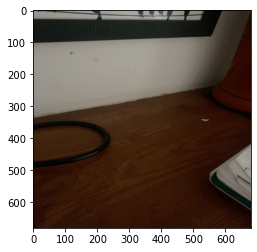

In [30]:
draw_preds_bbs(
    photo_filename, 
    [
        preds_pipeline['boxes'],
        preds_pipeline['scores'],
        
    ],
    is_coreml=True
)

In [917]:
quantized_model_pipeline.save('yolov4_tiny.mlmodel')